# Study of the stability of GECNETs controllers for BEBOP quad

In this notebook we study the linear stability of a Guidance and Control network (GECNET) controlling a simple quad dynamics (NOTE: a drag term is present with empirical ballistic coefficient as determined at TU Delft CyberZOO experiments)

$$
\left\{
\begin{array}{l}
\dot x = v_x \\
\dot v_x = \frac{u_1}{m} \sin(\theta) - \frac 12 v_x\\
\dot z = v_z \\
\dot v_z = \frac{u_1}{m} \cos(\theta) - g_0 - \frac 12 v_z\\
\dot \theta = u_2
\end{array}
\right.
$$

The network is designed so that $\mathcal N(\mathbf x) = \mathbf u$, that is: $\mathcal N([x,v_x,z,v_z, \theta]) = [u_1, u_2]$, represents the solution to the optimal control problem of driving the dynamics to the origin minimizing the quadratic control. 

The following parameters are used, corresponding to the bebop drone.

Bebop: 
${|u_1|}_{max}$ = 9.1 [N], ${|u_2|}_{max}$ = 35 [rad/sec], m= 0.38905 Kg, $g_0 = 9.81$ [m/s$^2$]



| Packages needed    | 
|----------|
| scipy  | 
| numpy  | 
| matplotlib  | 
| pyaudi  |
| pygmo  |
| progressbar  |
| control  |


Can all be installed via pip  or conda package managers (tested in python 3.7)

In [1]:
%matplotlib inline

import pygmo as pg
from pyquad import Controller, rkf45, rkf45_gduals, rk4_fixed
import numpy as np
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos, sqrt, tanh
import progressbar

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

g0 = 9.81 # m/s2
m = 0.38905 # kg
T_max = 9.1 # N
theta_max = 35 # rad/sec

# Change this to use a different network
pickled_controller_path = "data/softplus/power_bebop_drag_h03_n0100_softplus.pkl"

### 1 - Find the exact equilibrium point



In [2]:
# This pygmo problem is solved by the equilibrium point of the system
class find_equilibrium:
    def __init__(self, path = pickled_controller_path):
        self.Controller = Controller(pickled_controller_path)
    def fitness(self, x):
        return [np.linalg.norm(self.Controller.compute_control(x) - np.array([g0*m, 0]))]
    def get_bounds(self):
        return ([-1,0,-1,0,0],[1,0,1,0,0])

In [3]:
udp = find_equilibrium(path = pickled_controller_path)
prob = pg.problem(udp)
algo = pg.algorithm(pg.de(gen=300, xtol=1e-15, ftol=1e-15))
pop = pg.population(prob,19)
pop.push_back([0,0,0,0,0])
pop = algo.evolve(pop)


In [4]:
bias = pop.champion_x
print("Equilibrium point is: ", bias)
print("The controls at equilibrium are: ", udp.Controller.compute_control(bias))
print("The acceleration is thus: ", udp.Controller.compute_control(bias)[0] / m)

Equilibrium point is:  [0.00026167 0.         0.00192276 0.         0.        ]
The controls at equilibrium are:  [ 3.81658050e+00 -1.11109039e-15]
The acceleration is thus:  9.809999999999992


### 2 - Redefine the Controller so that the origin is the equilibrium point


In [5]:
class UnbiasedController(Controller):
    def __init__(self, path_to_pickle, bias):
        super(UnbiasedController, self).__init__(path_to_pickle)
        self.bias = np.array(bias)
    def compute_control(self, state):
        return super(UnbiasedController, self).compute_control(state + bias)

In [6]:
uc = UnbiasedController(pickled_controller_path, bias)


In [7]:
a = uc.compute_control([0,0,0,0,0])
print("Network output at equilibrium: ", a[0] / m, a[1])

Network output at equilibrium:  9.809999999999992 -1.111090386363145e-15


### 3 - Simulate the dynamics

In [8]:
def rhs(t, x):
    u = uc.compute_control(x)
    return np.array([
        x[1],
         -0.5*x[1] + (u[0])/m * sin(x[4]),
        x[3],
        -0.5 *x[3] - g0 + (u[0])/m * cos(x[4]),
         u[1],
    ])

In [9]:
# Initial condition for the plots (x,vx,z,vz,theta)
IC = np.array([ 4. ,2., 7.,1.,1.4])


tf = 3.2
N = 100
# We used a fixed step integrator to be able to make a movie later
res = rk4_fixed(rhs, 0, IC, tf, N)

x = res[:,0]
vx = res[:,1]
z = res[:,2]
vz = res[:,3]
theta = res[:,4]
t = np.arange(0, tf, tf/ N)

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


#### Trajectory plot

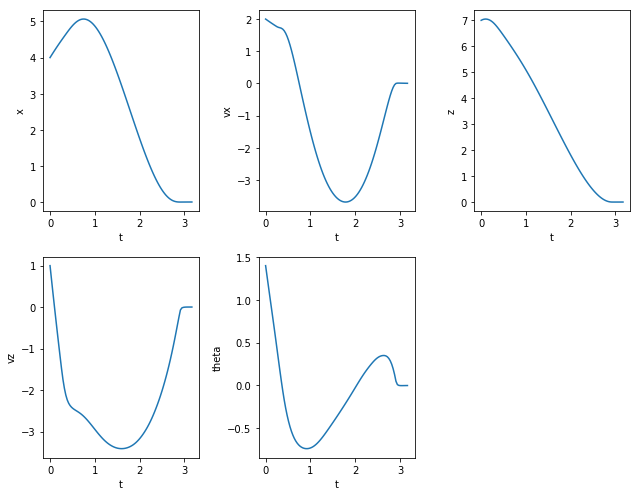

In [10]:
# And we plot (statically) the resulting trajectory
plt.figure(figsize=(9,7))
plt.subplot(231)
plt.plot(t, x)
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(232)
plt.plot(t, vx)
plt.xlabel("t")
plt.ylabel("vx")
plt.subplot(233)
plt.plot(t, z)
plt.xlabel("t")
plt.ylabel("z")
plt.subplot(234)
plt.plot(t, vz)
plt.xlabel("t")
plt.ylabel("vz")
plt.subplot(235)
plt.xlabel("t")
plt.ylabel("theta")
plt.plot(t, theta)
plt.tight_layout()

(-8, 8)

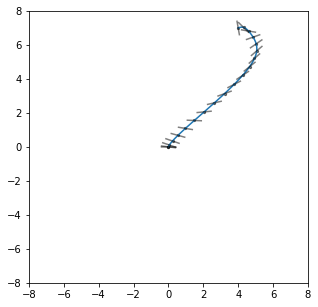

In [11]:
def plot_quad_traj(x,z,theta, L, ax):
    # Quad Terminal points
    x1 = x + L * np.cos(theta)
    z1 = z - L * np.sin(theta)
    x2 = x - L * np.cos(theta) 
    z2 = z + L * np.sin(theta) 

    ax.plot(x,z)
    for i in range(len(x1))[::5]:
        ax.plot([x1[i],x2[i]], [z1[i],z2[i]],"k", alpha=0.5)
        ax.scatter(x[i],z[i], s=5,color='k', alpha=0.5)
        
L=0.4
fig = plt.figure(figsize=(5,5))
plot_quad_traj(x,z,theta, L,fig.gca())
plt.xlim((-8, 8))
plt.ylim((-8, 8))


#### Animated Plot

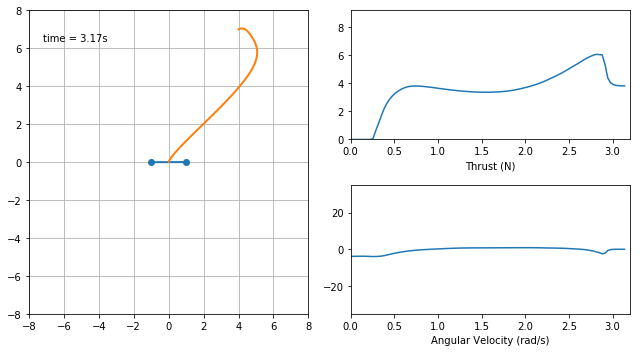

In [12]:
L = 1
dt = (tf - 0) / N

# Quad Terminal points
x1 = x + L * np.cos(theta)
z1 = z - L * np.sin(theta)
x2 = x - L * np.cos(theta) 
z2 = z + L * np.sin(theta) 

# The control
u = np.array([uc.compute_control(i) for i in res])

fig = plt.figure(figsize=(9,5))

ax = fig.add_subplot(121, autoscale_on=False, xlim=(-8, 8), ylim=(-8, 8))
ax.grid()

quad, = ax.plot([], [], 'o-', lw=2)
traj, = ax.plot([], [], '-', lw=2)

time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ax = fig.add_subplot(222, autoscale_on=False, xlim=(0, tf), ylim=(0, T_max+0.1))
thrust, = ax.plot([], [], '-')
plt.xlabel("t")
plt.xlabel("Thrust (N)")

ax = fig.add_subplot(224, autoscale_on=False, xlim=(0, tf), ylim=(-theta_max-0.1, theta_max+0.1))
torque, = ax.plot([], [], '-')
plt.xlabel("t")
plt.xlabel("Angular Velocity (rad/s)")

plt.tight_layout()

def init():
    quad.set_data([], [])
    traj.set_data([],[])
    thrust.set_data([], [])
    torque.set_data([], [])
    time_text.set_text('')
    return quad, time_text


def animate(i):
    thisx = [x1[i], x2[i]]
    thisy = [z1[i], z2[i]]

    quad.set_data(thisx, thisy)
    traj.set_data(x[:i], z[:i])
    time_text.set_text(time_template % (i*dt))
    thrust.set_data(t[:i], u[:i,0])
    torque.set_data(t[:i], u[:i,1])
    return quad, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(z)),
                              interval=25, blit=True, init_func=init)

rc('animation', html='html5')
ani.save('assets/quad_traj.gif', fps=15, writer='imagemagick')
ani


#### Plots for different initial conditions IC

100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (99 of 99) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


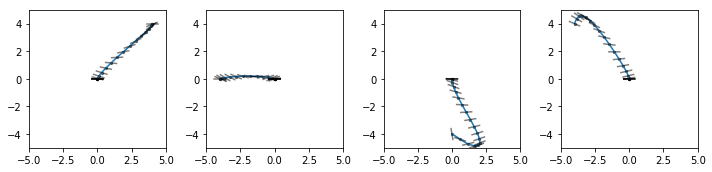

In [13]:
IC = []
IC.append(np.array([ 4. ,0, 4.,0,0]))
IC.append(np.array([ -4. ,0, 0,0,0]))
IC.append(np.array([ 0. ,4., -4.,-2.,1.4]))
IC.append(np.array([ -4. ,1., 4.,3.,0.4]))

L=0.4
tf = 3.
N = 100

fig = plt.figure(figsize=(10,2.5))
for i,x0 in enumerate(IC):
    ax = plt.subplot(1,4,i+1)
    res = rk4_fixed(rhs, 0, x0, tf, N)
    plot_quad_traj(res[:,0],res[:,2],res[:,4], L,ax)
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
plt.tight_layout()
plt.savefig("assets/trajs.png", dpi=600)



### 4 - Analyze the System Stability (linear)

The system linear stabilty around the equilibrium point (origin) is studied. 

Write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x)
$$

introduce the variable $\mathbf x = \mathbf x_e + \delta \mathbf x$. Then:

$$
\dot {\delta \mathbf x} = \nabla \mathbf f \cdot \delta \mathbf x
$$

The resulting linear system has an analytical solution readily found by:

$$
\delta \mathbf x = e^{\mathbf A t} \delta \mathbf x_0
$$

Using the eigen decomposition of the matrix $\mathbf A$ we may write $\mathbf A\mathbf V = \mathbf V\mathbf \Lambda$. Where we have introduced the right eigenvector matrix $\mathbf V = [\mathbf v_1, \mathbf v_2, ...]$ and the eigenvalue matrix $\mathbf \Lambda$. 

Eventually the system dynamics is thus expressed as:

$$
\delta \mathbf x = \mathbf V^{-1} e^{\mathbf \Lambda t} \mathbf V 
$$

and will thus be some linear combination of terms in the form $e^{-\lambda_i t}$. The real part of the eigenvalues is then determining the asymptotic behavior of the system (needs to be negative to give asymptotic stability and its magnitude regulates the system damping time), while the imaginary part $\omega_i$ determines the oscillating behaviour introducing a frequency $f = \frac {\omega}{2\pi}$.

In [14]:
# Equilibrium point defined as a generalized dual number (pyaudi) so that forward differentiation will include these vars.
x_e = [gdual(0., name, 1) for name in ["x","vx","z","vz","th"]]

In [15]:
# We compute the gradient of the rhs
lin_dyn = rhs(0, x_e)
# We make sure all relevant symbols are there
ss = ["dx", "dvx", "dz", "dvz", "dth"]
_ = [a.extend_symbol_set(ss) for a in lin_dyn]

In [16]:
# We compute the linear part of the neurocontrolled dynamics A
A = np.eye(5)
for i in range(5):
    for  j in range(5):
        A[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})

In [17]:
# And its spectral properties
lambdas, eigv = np.linalg.eig(A)
for i, lam in enumerate(lambdas):
    alpha = lam.real
    beta = lam.imag
    print("Mode ", i+1, ": ", end='')
    if alpha < 0:
        print("STABLE!", end = '')
        if beta!=0:
            print(" - complex", end='')
            print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s")
            print("\t dampded frequency: ", 2*np.pi/beta, "s")
        else:
            print(" - real", end='')
            print("\n\t decay time (10%): ", np.log(0.1)/alpha, "s")
    else:
        print("UNSTABLE!")

Mode  1 : STABLE! - real
	 decay time (10%):  0.04474292066675358 s
Mode  2 : STABLE! - real
	 decay time (10%):  0.03360179684536022 s
Mode  3 : STABLE! - complex
	 decay time (10%):  0.8527648923632102 s
	 dampded frequency:  3.592605057745553 s
Mode  4 : STABLE! - complex
	 decay time (10%):  0.8527648923632102 s
	 dampded frequency:  -3.592605057745553 s
Mode  5 : STABLE! - real
	 decay time (10%):  1.8026112464952624 s


### 5 - Analyze the System Stability to time delays (linear)

The system linear stabilty around the equilibrium point (origin) is studied when a time delay $\tau$ is introduced in the control input.

We write the overall system as:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathbf x^\tau)
$$

and, again considering small displacements around the stable equilibrium point at the origin, we have the representation:

$$
\dot {\delta \mathbf x} = \mathbf A \delta \mathbf x + \mathbf B \delta \mathbf x^\tau 
$$

where we have used the notation $\mathbf x = \mathbf x(t)$, $\mathbf x^\tau = \mathbf x(t-\tau)$.

This linear system with time delay has the general solution:

$$
\delta \mathbf x(t) = e^{\Phi t}\mathbf x_0
$$

where the matrix $\mathbf \Phi$ eigenvalues are obtained from the time-delayed characteristic equation:

$$
\left|\mathbf A + \mathbf Be^{-\lambda \tau} - \lambda\mathbf I\right| = 0
$$

note that for $\tau =0$ (no delay) we recover the stability study of the undelayed system.


In [18]:
# We write the dynamics as a function of both the signal and the delayed signal
def rhs_delay(t, x, xtau):
    u = uc.compute_control(xtau)
    return np.array([
        x[1],
        - 0.5 * x[1] + u[0]/m * sin(x[4]),
        x[3],
        -0.5 * x[3] - g0 + u[0]/m * cos(x[4]),
         u[1],
    ])

In [19]:
# We compute the gradient of rhs_delay w.r.t. x and thus A (we call it Ad to retain A in the notebook)
xtau_e = [gdual(0., name, 1) for name in ["xt","vxt","zt","vzt","tht"]]
lin_dyn = rhs_delay(0., x_e, xtau_e)
ss = ["dx", "dvx", "dz", "dvz", "dth", "dxt", "dvxt", "dzt", "dvzt", "dtht"]
_ = [a.extend_symbol_set(ss) for a in lin_dyn]
Ad = np.eye(5)
for i in range(5):
    for  j in range(5):
        if lin_dyn[i].order == 0: # its a constant
            Ad[i,j] = 0
        else:
            Ad[i,j] = lin_dyn[i].get_derivative({ss[j] : 1})

In [20]:
# We compute the gradient of rhs_delay w.r.t. x_tau and thus B (we call it Bu to retain B in the notebook)
Bu = np.eye(5)
for i in range(5):
    for  j in range(5):
        if lin_dyn[i].order == 0: # its a constant
            Bu[i,j] = 0
        else:
            Bu[i,j] = lin_dyn[i].get_derivative({ss[j+5] : 1})

In [21]:
# This must be zero if x[0] is the crossing of the imaginary axis and x[1] the time delay when it happens.
# NOTE: a good initial guess i needed as to be sure not to find one of the other crossings
def stability_margin(x, A, B):
    # x is [imag, tau], real assumed to be zero
    lam = 1j*x[0]
    det = np.linalg.det(B*np.exp(-lam*x[1])+A-lam*np.eye(5))
    return [det.real, det.imag]

In [22]:
from scipy.optimize import root
sol = root(stability_margin, [100, 0.014], (Ad, Bu), tol=1e-10)
print("Margin found is: ", sol.x[1], "s")
print("Precision obtained: ", np.linalg.norm(stability_margin(sol.x, Ad, Bu)))

Margin found is:  0.022505276283764163 s
Precision obtained:  0.0006088177224381053


In [23]:
# This is zero if x is eigenvalue
def time_delay_eq(x, tau, A,B):
    # x is [real, imag]
    lam = x[0] + 1j*x[1]
    det = np.linalg.det(B*np.exp(-lam*tau)+A-lam*np.eye(5))
    return [det.real, det.imag]

In [24]:
# This is to find all eigenvalues
from scipy.optimize import root
from copy import deepcopy
tau = np.linspace(0,0.052,1000)

   
newlam = [[0. for i in range(len(lambdas))] for i in range(len(tau))]
lambdas0 = deepcopy(lambdas)
for i, delay in enumerate(tau):
    for j, lam in enumerate(lambdas0):
        success = False
        while not success:
            sol = root(time_delay_eq, [lam.real, lam.imag], (delay, Ad, Bu), tol=1e-10)
            success = sol.success
            newlam[i][j] = sol.x
            real0, imag0 = sol.x
            lam = lam.real +1j*(lam.imag+.1)
    lambdas0 = np.array([ a + 1j*b for a,b in newlam[i]])

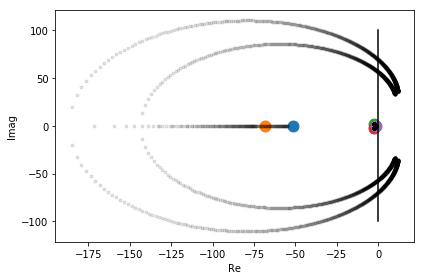

In [25]:
# Plot the root locu w.r.t timedelay

fig = plt.figure(figsize=(6,4)) 
c = ["g","r","b","y", "k"]
ax = fig.add_subplot(111)
datax = []
datay = []
for lambdas2 in newlam[20:]:
    for i,a in  enumerate(lambdas2):
        datax.append(a[0])
        datay.append(a[1])
        if abs(a[1]) > 1e-10:
            datax.append(a[0])
            datay.append(-a[1])
ax.plot(datax,datay, 'k.', alpha=0.1)
ax.plot([0,0],[-100,100], 'k-')
[ax.scatter(l.real, l.imag, alpha=1., s=120) for l in lambdas]
plt.xlabel("Re")
plt.ylabel("Imag")
    
plt.tight_layout()
plt.savefig("assets/locusrootN_3_100.png")

## Anlaysis using Pade approximant

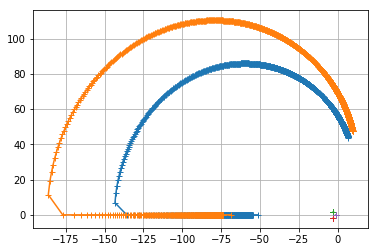

In [26]:
# find the maximum allowable delay
import numpy as np
import scipy.linalg as scl
import control

def padecoeff (tau, order=2, tf_flag=False):
    '''Calculate the Pade approximation a delay.

    Arg:
        tau (float): The delay to be approximated.
        order (int): The order of the approximation.
        tf_flag (bool, optional): If set returns the
            numerator and the denominator of the Pade
            approximation, or else the state space
            matrices. Default is False.

    Returns:
        A, B, C, D (numpy array): The state space matrices.
        num, dem (numpy array): Numerator and denominator
            of the system. If tf_flag is set.
    '''
    # first calculate numerator and denominator
    num = np.ones(order+1)
    den = np.ones(order+1)
    fact = np.math.factorial
    for ip in range(0,order):
        den[ip+1] = fact(2*order-ip-1)*fact(order)/fact(2*order) \
            /fact(ip+1)/fact(order-ip-1)*tau**(ip+1);
        num[ip+1] = den[ip+1]*(-1)**(ip+1);
    num = np.flip(num, axis=0)
    den = np.flip(den, axis=0)
    num = num/np.abs(num[0])
    den = den/np.abs(den[0])

    if tf_flag:
        return num, den
    else:
        # controllable canonical form
        A = np.zeros((order,order))
        B = np.zeros((order,1))
        C = np.zeros((1,order))
        D = num[0]
        
        for ik in range(0,norder-1):
            A[ik,ik+1] = 1.
        A[order-1,:] = -np.flip(den[1:], axis=0)
        B[order-1,0] = 1.
        C[0,:] = np.flip(num[1:], axis=0) + A[order-1,:]*D

        return A, B, C, D

# start the computation
A = Ad

B = Bu


# do the calculations
norder = 5
ntau = 2000
nstate = A.shape[0]

tau_vec = np.linspace(0.001, 0.037, ntau)
eig_vec = np.zeros((ntau+1,nstate), dtype=complex)
eig_tmp2 = np.zeros(nstate, dtype=complex)
eig_nd = np.linalg.eigvals(A + B);
eig_vec[0,:] = eig_nd
del_crit = None

for ik in range(0,ntau):
    # calculate the delay
    # use the function above or the one
    # from the contol package
    # Ap, Bp, Cp, Dp = padecoeff(tau_vec[ik], norder)
    nump, denp = control.pade(tau_vec[ik], norder)
    Ap, Bp, Cp, Dp = control.ssdata(control.tf2ss(nump, denp))
    
    Ap = scl.block_diag(*((Ap,)*nstate))
    Bp = scl.block_diag(*((Bp,)*nstate))
    Cp = scl.block_diag(*((Cp,)*nstate))
    Dp = scl.block_diag(*((Dp,)*nstate))

    # interconnect the system
    Ad11 = A+np.matmul(B,Dp)
    Ad12 = np.matmul(B,Cp)
    Ad1 = np.concatenate((Ad11,Ad12), axis=1)
    Ad2 = np.concatenate((Bp,Ap), axis=1)
    Adel = np.concatenate((Ad1,Ad2), axis=0)

    eig_tmp = np.linalg.eigvals(Adel)
    #if np.any(np.real(eig_tmp)>0):
    #    print('Here', tau_vec[ik])

    # find eigenvaues closest to the original
    eig_tmp2.fill(0.)
    for ip in range(0, nstate):
        idx_m = np.argmin(np.abs(eig_tmp - eig_vec[ik,ip]))
        eig_tmp2[ip] = eig_tmp[idx_m]
        np.delete(eig_tmp, idx_m)
    eig_vec[ik+1,:] = eig_tmp2

    # find critical delay
    if (del_crit is None) and np.any(np.real(eig_tmp2)>0):
        del_crit = 0.5*(tau_vec[ik] + tau_vec[ik-1])
    
        
# make a plot
fig = plt.figure() 
plt.plot(np.real(eig_vec), np.imag(eig_vec), '-+')
plt.grid()
plt.show()


## Analysis using High Order Taylor Maps

In [27]:
from pyaudi import gdual_double as gdual
from pyaudi import sin, cos
import time
import pickle
# Uncomment here to generate the map (at order 7 may take more than 10 hours, try order 3 first)
order = 7
IC = np.array([ gdual(-4.,"x",order) , gdual(0.,"vx",order),  gdual(0.,"z",order), gdual(0.,"vz",order), gdual(0.,"t",order)])
tf = 3.
# Uncomment here to generate the maps M_i (one per veariable per timestep)
#t2, maps = rkf45_gduals(rhs,0,IC,tf,tol=1e-10,h0=1e-3)

# Otherwise use a pickled one
file = open("data/taylormaps/taylor_model_7_N_100_3.pk","rb")
t2, maps = pickle.load(file)


In [28]:
# Renaming the maps as to highlight the single variables
x = maps[:,0]
vx = maps[:,1]
z = maps[:,2]
vz = maps[:,3]
theta = maps[:,4]
# Variations from the reference trajectory
dx =  0.25
dvx = 0.25
dz =  0.25
dvz = 0.25
dt =  0.25

# The new trajectory as expressed by the map
newx = [it.evaluate({"dx":dx, "dvx":dvx, "dz":dz, "dvz":dvz,"dt":dt}) for it in x]
newvx = [it.evaluate({"dx":dx, "dvx":dvx, "dz":dz, "dvz":dvz,"dt":dt}) for it in vx]
newz = [it.evaluate({"dx":dx, "dvx":dvx, "dz":dz, "dvz":dvz,"dt":dt}) for it in z]
newvz = [it.evaluate({"dx":dx, "dvx":dvx, "dz":dz, "dvz":dvz,"dt":dt}) for it in vz]
newtheta = [it.evaluate({"dx":dx, "dvx":dvx, "dz":dz, "dvz":dvz,"dt":dt}) for it in theta]

# The reference trajectory as expressed by the map
refx = [it.constant_cf for it in x]
refvx = [it.constant_cf for it in vx]
refz = [it.constant_cf for it in z]
refvz = [it.constant_cf for it in vz]
reftheta = [it.constant_cf for it in theta]
newt = t2

In [29]:
# We call the simulator to compute the real trajectory 
IC = np.array([ dx-4. ,dvx, dz,dvz,dt])
#IC = np.array([ -7., 0., 0., 0., 0.])
#IC = np.array([ 0., 0., 7., 0., 0.])

tf = 3
N = 1000

res_d = rk4_fixed(rhs, 0, IC, tf, N)

x = res_d[:,0]
vx = res_d[:,1]
z = res_d[:,2]
vz = res_d[:,3]
theta = res_d[:,4]
t = np.arange(0, tf, tf/ N)

100% (999 of 999) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


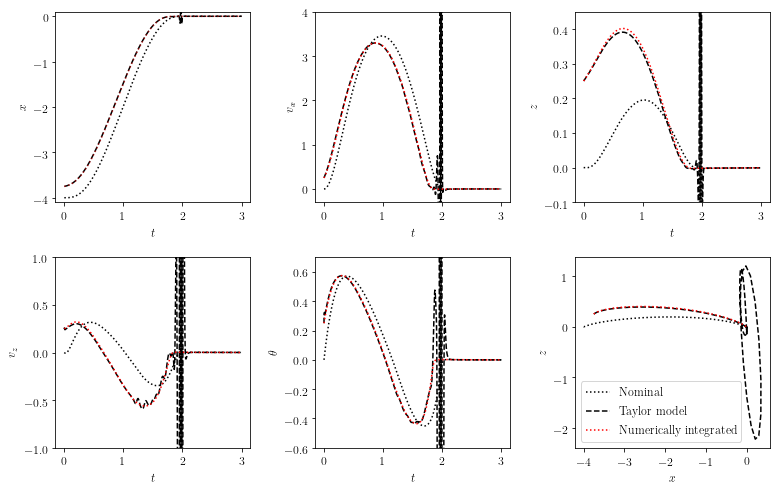

In [30]:
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
alpha = 1
# And we plot (statically) the resulting trajectory
plt.figure(figsize=(11,7))
plt.subplot(231)
plt.plot(newt, refx, alpha = alpha, color='k', linestyle=":")
plt.plot(newt, newx, alpha = alpha, color='k', linestyle="--")
plt.plot(t, x, alpha = 0.5, color='r', linestyle=":")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.ylim([-4.1,0.1])
plt.subplot(232)
plt.plot(newt, refvx, alpha = alpha, color='k', linestyle=":")
plt.plot(newt, newvx, alpha = alpha, color='k', linestyle="--")
plt.plot(t, vx, alpha = alpha, color='r', linestyle=":")
plt.xlabel("$t$")
plt.ylabel("$v_x$")
plt.ylim([-0.3,4])
plt.subplot(233)
plt.plot(newt, refz,alpha = alpha, color='k', linestyle=":")
plt.plot(newt, newz,alpha = alpha, color='k', linestyle="--")
plt.plot(t, z, alpha = alpha, color='r', linestyle=":")
plt.xlabel("$t$")
plt.ylabel("$z$")
plt.ylim([-0.1,0.45])
plt.subplot(234)
plt.plot(newt, refvz, alpha = alpha, color='k', linestyle=":")
plt.plot(newt, newvz, alpha = alpha, color='k', linestyle="--")
plt.plot(t, vz, alpha = alpha, color='r', linestyle=":")
plt.xlabel("$t$")
plt.ylabel("$v_z$")
plt.ylim([-1,1])
plt.subplot(235)
plt.xlabel("$t$")
plt.ylabel("$\\theta$")
plt.ylim([-0.6,0.7])
plt.plot(newt, reftheta, alpha = alpha, color='k', linestyle=":")
plt.plot(newt, newtheta, alpha = alpha, color='k', linestyle="--")
plt.plot(t, theta, alpha = alpha, color='r', linestyle=":")
plt.subplot(236)
plt.xlabel("$x$")
plt.ylabel("$z$")
plt.plot(refx, refz, alpha = alpha, color='k', linestyle=":", label = "Nominal")
plt.plot(newx, newz, alpha = alpha, color='k', linestyle="--", label = "Taylor model")
plt.plot(x, z, alpha = alpha, color='r', linestyle=":", label = "Numerically integrated")
plt.legend()

plt.tight_layout()
plt.savefig("assets/taylormodel.png")

In [31]:
x = maps[:,0]
vx = maps[:,1]
z = maps[:,2]
vz = maps[:,3]
theta = maps[:,4]

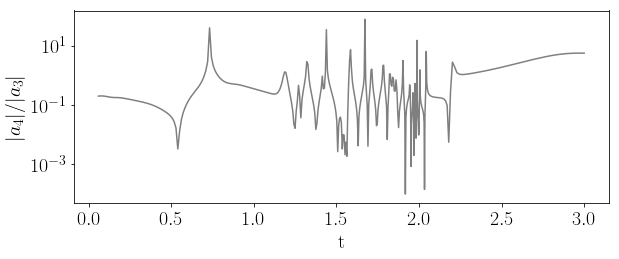

In [32]:
plt.figure(figsize=(9,4))
plt.rc('font', family='serif', size=20)
plt.rc('text', usetex=True)
resss = []
for i in range(10, len(newt)):
    s = [vz[i].extract_terms(j).evaluate({"dx": 1,"dvx": 1,"dz": 1,"dvz": 1,"dt":1}) for j in [1,2,3,4,5,6,7]]
    resss.append(abs(s[5])/abs(s[6]))
plt.semilogy(newt[10:], resss, 'k', alpha=0.5)
plt.xlabel("t")
plt.ylabel("$|a_4| / |a_3|$")
plt.tight_layout()
plt.savefig("assets/convergence_radius.png")